<a href="https://colab.research.google.com/github/emm-gl/WA2501_Machine_Learning_AI/blob/main/Exam_Module_III_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Examen Working Analyst
##Módulo III: deep learning

### **Examen práctico**

Desarrolle un clasificador de reseñas de hoteles (positivas y negativas) utilizando una red neuronal recurrente (RNN, por sus siglas en
inglés). El archivo csv se encuentra disponible en este [enlace](https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv):

Para ello, utilice un modelo secuencial que
tenga las siguientes capas:
* Una capa de embedding (que no se entrene, que utilice el modelo word2vec).

* Una capa LSTM de con tantas unidades como dimensiones tenga el modelo word2vec utilizado, y un dropout de 0.2.

* Una capa de salida con 1 neurona para la clase de cada reseña. Para esta capa
elige una función de activación conveniente para la clasificación binaria.

Alumno: Emmanuel Gonzalez Calitl

c.egonca@icloud.com

Mayo 2025


## Install and import packages

Install gensim, then restart the runtime and continue running the next cells:

In [1]:
#!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import gensim
from collections import Counter

from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

## Preprocessing functions:

In [3]:
!pip install contractions
import contractions

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer  ## SnowballStemmer (para español)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def elimina_stopwords(texto):
  '''La función usa expresiones regulares (re) para quitar todas las palabras
  que sean una palabra vacia:'''
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [6]:
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub('[^a-z]+', ' ', texto)
  return nuevo_texto

In [7]:
def lematizar(texto):
  lemma = WordNetLemmatizer()
  texto = texto.split()
  texto2 = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  nuevo_texto = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  return nuevo_texto

In [8]:
def stemmer(texto):
  st = PorterStemmer()
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])
  return nuevo_texto

In [9]:
def preprocesar(texto):
  texto = contractions.fix(texto)
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)

In [10]:
def convert_polarity(polarity):
    if polarity == 'positive':
        return 1
    else:
        return 0

## Get dataset

In [11]:
csv_file ="https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv"
data = pd.read_csv(csv_file, encoding= 'unicode_escape')
data = data.fillna( method='ffill', axis=0)
data.head(3)

<ipython-input-11-ffd35d0e3974>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna( method='ffill', axis=0)


,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   hotel      1600 non-null   object
 2   polarity   1600 non-null   object
 3   source     1600 non-null   object
 4   text       1600 non-null   object
dtypes: object(5)
memory usage: 62.6+ KB


In [13]:
data.nunique()

,0
deceptive,2
hotel,20
polarity,2
source,3
text,1596


In [14]:
#Overview of the data set:

print("Number of registers:", len(data))

# Check for NaN values in each column
print("\nNaN values per column:")
print(data.isnull().sum())

# Check data types of each column
print("\nData types per column:")
print(data.dtypes)

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(data.describe())

# Value counts for categorical columns
for col in data.columns:
  if data[col].dtype == 'object':
    print(f'\nValue counts for column {col}:')
    print(data[col].value_counts())


Number of registers: 1600

NaN values per column:
deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64

Data types per column:
deceptive    object
hotel        object
polarity     object
source       object
text         object
dtype: object

Summary statistics for numerical columns:
       deceptive   hotel  polarity source  \
count       1600    1600      1600   1600   
unique         2      20         2      3   
top     truthful  conrad  positive  MTurk   
freq         800      80       800    800   

                                                     text  
count                                                1600  
unique                                               1596  
top     The Omni was chosen for it's location whichwor...  
freq                                                    2  

Value counts for column deceptive:
deceptive
truthful     800
deceptive    800
Name: count, dtype: int64

Value counts for column hotel:
hotel
conrad     

## Preprocessing the dataset:

In [15]:
df = data[['text', 'polarity']].copy()      #Just two main columns are needed
df = df.rename(columns={'text': 'original_review'})
df['long_NumWords'] = df['original_review'].str.split().str.len()
df['review'] = df['original_review'].apply(preprocesar)
df['prep_NumWords'] = df['review'].str.split().str.len()

df['polarity'] = df['polarity'].apply(convert_polarity)

df.head()

,original_review,polarity,long_NumWords,review,prep_NumWords
0,We stayed for a one night getaway with family ...,1,105,stay one night getaway famili thursday tripl a...,58
1,Triple A rate with upgrade to view room was le...,1,45,tripl rate upgrad view room less also includ b...,30
2,This comes a little late as I'm finally catchi...,1,207,come littl late final catch review past sever ...,104
3,The Omni Chicago really delivers on all fronts...,1,127,omni chicago realli deliv front spacious room ...,63
4,I asked for a high floor away from the elevato...,1,72,ask high floor away elev got room pleasantli d...,33


## Prepare the reviews that will be input to our neural network.

Padding: The LSTM layers require each sequence (sentence) to be the same length. Any length can be used, but the longer the length, the higher the training cost.

Shorter sentences will be "padded" with the token we added earlier ('PAD_token').

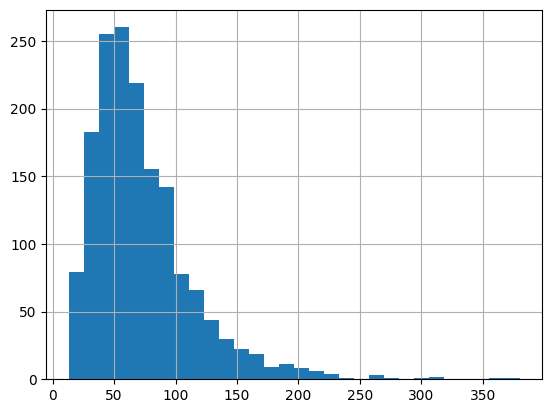

The mean number of words per review is: 72.498125
The largest review has 380 tokens



In [16]:
# Calculate the number of words in each review
word_count = df['review'].apply(lambda x: len(x.split()))
word_count.hist(bins=30)
plt.show()

print('The mean number of words per review is: {}'.format(word_count.mean()))
print('The largest review has {} tokens'.format(word_count.max()))
print()

In [17]:
# Fixed maximum length for padding
max_len = int(word_count.quantile(0.99))
max_len

216

### Tokenization and padding:

In [18]:
# Combine all reviews into a single string
all_reviews = ' '.join(df['review'])

# Split the string into words
words = all_reviews.split()
print("Number of words in the all reviews: {}".format(len(words)))
print("Number of unique words in the all reviews: {}".format(len(set(words))))

Number of words in the all reviews: 115997
Number of unique words in the all reviews: 6368


In [19]:
unique_words = set(words)
#print(unique_words)

In [20]:
# Tokenization
tokenizer = Tokenizer(num_words=None, oov_token='<OOV>') # oov_token para palabras fuera del vocabulario
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

# Padding
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [21]:
print("Padding Matrix shape:", padded_sequences.shape)

Padding Matrix shape: (1600, 216)


In [22]:
# Example usage with a single review
example_review = df['review'][10]
print("Original review:", example_review)

# Tokenize the example review
example_sequence = tokenizer.texts_to_sequences([example_review])
print("\nTokenized sequence:", example_sequence)

# Pad the example sequence
example_padded_sequence = pad_sequences(example_sequence, maxlen=max_len, padding='post', truncating='post')
print("\nPadded sequence:", example_padded_sequence)


Original review: stay fairmont chicago one night frequent busi travel familiar travel ritual check late almost pm due flight cancel home airport atlanta took shuttl airport best option lieu price taxi first time stay hotel upon arriv immedi notic entranc appear welcom warm check problem desk person even ask would prefer king doubl reconfirm reserv prefer alway take king bed fantast suit great linen incred feather pillow name encompass made pillow factori check tag sinc plan buy ate dinner hotel restaur aria mention like consid separ hotel ye stand food asian fusion truli wonder gourmand life long foodi appreci great food tast hotel servic good well drawback breakfast buffet restaur seem need stick dinner theme sole miss mark rel simpli thing like scrambl egg buffet tast bit metal made get special order made immedi pass buffet would highli recommend hotel atmospher great view get room one fabul dinner pass breakfast buffet

Tokenized sequence: [[4, 261, 5, 11, 10, 642, 45, 88, 2895, 88,

## Embedding:

In [106]:
# from google.colab import drive
# drive.mount('/content/drive')

In [107]:
# !pip install --upgrade gdown

In [108]:
# import gdown

# # ID del archivo y nombre de destino
# file_id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
# destination = "/content/drive/MyDrive/TrackCienciaDeDatos/Word2Vec/GoogleNews-vectors-negative300.bin.gz"

# # Descargar el archivo
# gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

In [23]:
from gensim.models import KeyedVectors

path = "/content/drive/MyDrive/TrackCienciaDeDatos/Word2Vec/GoogleNews-vectors-negative300.bin.gz"
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [27]:
word_index = tokenizer.word_index
num_tokens = len(word_index) + 1  # +1 by the padding
embedding_dim = 300


In [28]:
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

In [29]:
print("Embedding Matrix Shape:", embedding_matrix.shape)
print("Example vector, first 5 values:", embedding_matrix[3][:5])

Embedding Matrix Shape: (6370, 300)
Example vector, first 5 values: [ 0.02624512  0.1328125  -0.0234375   0.09130859  0.01806641]


## Obtener la matriz de encajes para todas las palabras del vocabulario (borrar)

<h2> Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3 millones de palabras y frases en inglés.
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# %%time
# # asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
# file =  '/content/drive/MyDrive/TrackCienciaDeDatos/Word2Vec/GoogleNews-vectors-negative300.bin.gz'
# w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

In [18]:

# print('Palabras en el modelo w2v: {:,} '.format(len(w2v.key_to_index)))
# print('Dimensiones por embedding: ', w2v.vector_size)

<h3> Reducción del diccionario de embeddings para tener solo los tokens presentes en nuestro corpus.

Guardar en pikle
Así no tendremos que volver a cargar todo el modelo word embedding

In [19]:
# dic_tokens_word2vec  = {}
# palabras_sin_embedding =[]
# for token in unique_words:
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     palabras_sin_embedding.append(token)

In [20]:
# import pickle
# import os # Import os module

# # Create the directory if it doesn't exist
# path = 'content/drive/MyDrive/TrackCienciaDeDatos/Word2Vec/Pikles/'

# # Now save the pickle file
# pickle.dump(dic_tokens_word2vec, open(path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [22]:
import pickle
path = '/content/drive/MyDrive/TrackCienciaDeDatos/Word2Vec/Pikles/'
w2v = pickle.load(open(path + "dic_tokens_ner_w2v.pkl", 'rb'))
palabras_sin_embedding = [tok for tok in unique_words if tok not in w2v.keys()]


In [25]:
print("Vocabulary of unique words: {}".format(len(unique_words)))
print("Words without embedding: {}".format(len(palabras_sin_embedding)))
print("Words with embedding: {}".format(len(w2v)))

Vocabulary of unique words: 10578
Words without embedding: 1732
Words with embedding: 8846


In [26]:
# Assuming 'df' is your DataFrame with 'review' and 'polarity' columns
# and 'palabras_sin_embedding' is your list of words without embeddings

# 1. Extract all words from the 'review' column:
all_review_words = ' '.join(df['review']).split()

# 2. Create a Series containing only the words without embeddings:
words_without_embeddings_series = pd.Series(all_review_words)[pd.Series(all_review_words).isin(palabras_sin_embedding)]

# 3. Calculate and display the frequencies:
word_frequencies = words_without_embeddings_series.value_counts(normalize=True).cumsum().head(50)

print("Top 50 most frequent words without embeddings and their cumulative frequencies:")
word_frequencies

Top 50 most frequent words without embeddings and their cumulative frequencies:


,proportion
and,0.277344
to,0.514841
a,0.741049
of,0.857354
didnt,0.868678
wasnt,0.874657
fairmont,0.877893
talbott,0.881023
amalfi,0.884012
sheraton,0.886685


In [27]:
##Embedding:
word_index = tokenizer.word_index
embedding_dim = 300#w2v.vector_size

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
   if word in w2v:
       embedding_matrix[i] = w2v[word]

In [28]:
len(embedding_matrix)

10580

In [29]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.080078,0.104980,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.071289,-0.030151,-0.013000,0.016357,-0.018311,0.014832,0.005005,0.003662,0.047607,-0.068848
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10575,-0.036865,0.205078,0.086914,-0.051758,0.067871,0.092285,-0.027466,0.390625,0.474609,0.259766,...,0.054932,0.023071,0.182617,0.154297,-0.263672,0.285156,-0.228516,0.061523,-0.026978,0.204102
10576,0.001266,0.014221,-0.071777,-0.248047,-0.314453,0.054932,0.189453,-0.139648,0.417969,0.259766,...,0.193359,0.168945,-0.024536,-0.034180,-0.090820,-0.361328,0.335938,-0.019287,0.123535,0.005188
10577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10578,0.082031,0.250000,-0.070312,0.108887,-0.130859,0.026855,-0.009705,-0.035156,-0.125977,-0.238281,...,0.100586,-0.249023,0.123047,-0.016235,-0.175781,-0.091309,-0.128906,-0.036865,-0.078613,0.161133


## Trainning:

In [30]:
X = padded_sequences
Y = df['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=42)

In [31]:
vocab_size = embedding_matrix.shape[0]
vocab_size

6370

In [32]:
embedding_dim = embedding_matrix.shape[1]
embedding_dim

300

In [33]:
#1. Input Layer
input = Input(shape=(max_len,), name="input_layer")

#2. Embedding Layer, no trainable, using w2v
embedding = Embedding(
                      input_dim=vocab_size,
                      output_dim=embedding_dim,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_len,
                      trainable=False,
                      name="embedding_layer"
                  )(input)

# 3. Layer LSTM with dropout 0.2
lstm = LSTM(
            units=embedding_dim,
            dropout=0.2,
            name="lstm_layer"
        )(embedding)

# 4. Output Layer: Binary Classification
output = Dense(1, activation='sigmoid', name="output_layer")(lstm)


model = Model(inputs=input, outputs=output, name="Word2Vec_LSTM_Model")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Word2Vec_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 216, 300)       │     1,911,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,501 (10.04 MB)

 Trainable params: 721,501 (2.75 MB)

 Non-trainable params: 1,911,000 (7.29 MB)

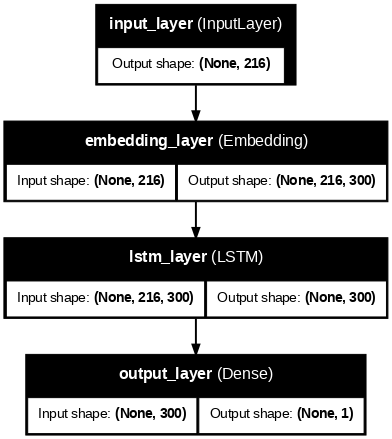

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    show_shapes=True,       # Muestra las dimensiones de entrada/salida por capa
    show_layer_names=True,  # Muestra los nombres definidos en cada capa
    expand_nested=False,    # Por si hay submodelos, no expandirlos
    dpi=70,                 # Resolución
    to_file='modelo_word2vec_lstm.png'  # Guarda imagen (opcional)
)


In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8378 - loss: 0.4196 - val_accuracy: 0.7500 - val_loss: 0.5405
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8054 - loss: 0.5019 - val_accuracy: 0.8750 - val_loss: 0.3777
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8542 - loss: 0.4047 - val_accuracy: 0.8687 - val_loss: 0.4038
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8651 - loss: 0.3868 - val_accuracy: 0.8875 - val_loss: 0.3183
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8738 - loss: 0.3486 - val_accuracy: 0.8719 - val_loss: 0.3409
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8676 - loss: 0.3658 - val_accuracy: 0.9062 - val_loss: 0.2914
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8081 - loss: 0.4997 - val_accuracy: 0.9031 - val_loss: 0.3177
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8966 - loss: 0.3197 - val_accuracy: 0.9156 - v

## Evaluation:

In [46]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss:.4f}")
print(f"Accuracy): {accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8964 - loss: 0.2913
Loss: 0.3058
Accuracy): 0.8969


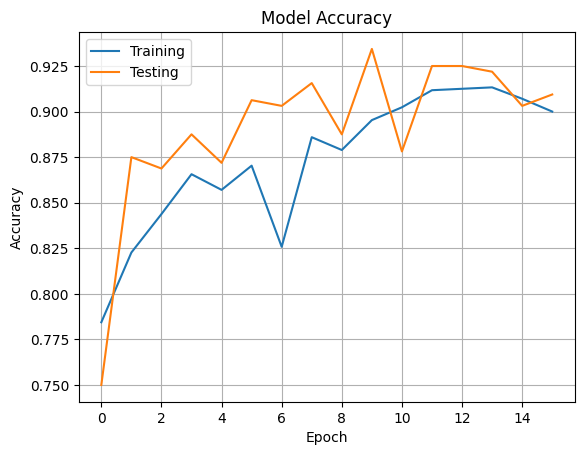

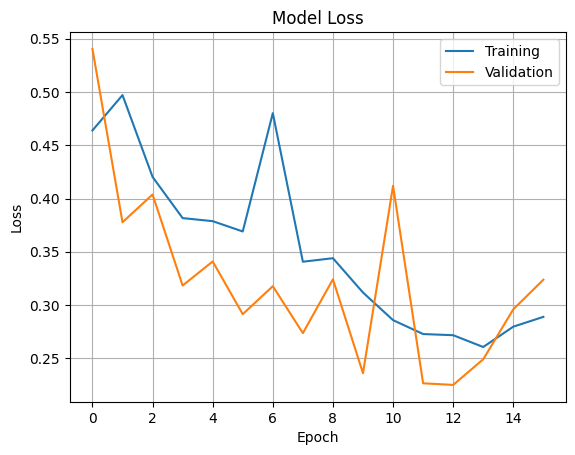

In [47]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()
